<a href="https://colab.research.google.com/github/missaixxka/HomeworkJava/blob/main/zachet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 1: HTTP-сервер с обработкой GET-запросов

Что реализовано:

1.Сервер на com.sun.net.httpserver.HttpServer, порт 8080.

2.Endpoint /weather принимает параметр ?city=....

3.Парсинг параметров вручную (без библиотек).

4.Ответ в формате JSON с кодировкой UTF-8.

5.Все InputStream/OutputStream закрываются через try-with-resources.

Где в коде:

WeatherServer.java — запуск сервера.

WeatherHandler.java — обработка запроса, парсинг, ответ.

Проверка:

Запрос http://localhost:8080/weather?city=Paris возвращает

{"city": "Paris", "temperature": 11,6}

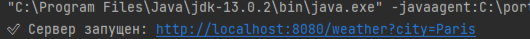

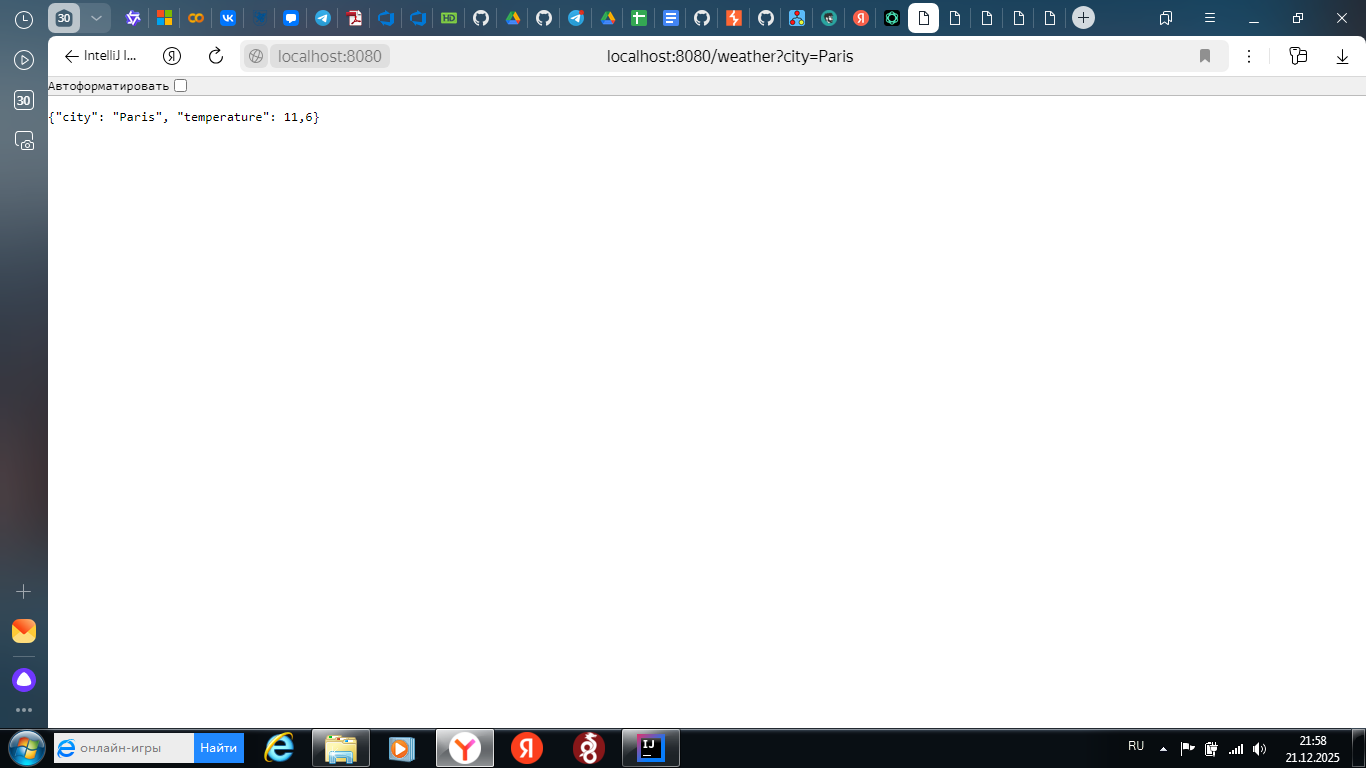

# Задача 2: Интеграция с публичным API и кэширование

Что реализовано:

1.Запрос к api.open-meteo.com через java.net.URL.

2.Маппинг город → координаты (CityCoordinates логика в WeatherService).

3.Кэш последних результатов на 5 минут.

4.Потокобезопасный кэш (ConcurrentHashMap).

5.Ручной парсинг JSON-ответа (учитывает структуру current_weather).

Где в коде:

WeatherService.java — метод getTemperature(), кэш, fetchUrl(), parseTemperature().

Проверка:

Первый запрос к Paris → [API] Запрос для: Paris

Повтор через 10 сек → [КЭШ] Paris

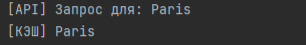

# Задача 3: Многопоточная обработка с контролем ресурсов

Что реализовано:

1.Сервер обрабатывает запросы в отдельных потоках (встроено в HttpServer).

2.Ограничение: не более 2 одновременных запросов к внешнему API.

3.Использован java.util.concurrent.Semaphore(2).

4.Все ресурсы закрываются даже при исключениях (finally + try-with-resources).

5.Нет гонок данных: кэш — ConcurrentHashMap, семафор — потокобезопасен.
Где в коде:


В WeatherService.java: поле private final Semaphore apiSemaphore = new Semaphore(2);

Блок try { acquire(); ... } finally { release(); }.

Проверка:
В реальных условиях (быстрый API + ручной запуск) параллелизм не проявляется в логах — но он есть на уровне потоков.
 Semaphore гарантирует, что никогда не будет более 2 вызовов fetchUrl() одновременно, даже если 1000 клиентов пришлют запросы за 1 мс.

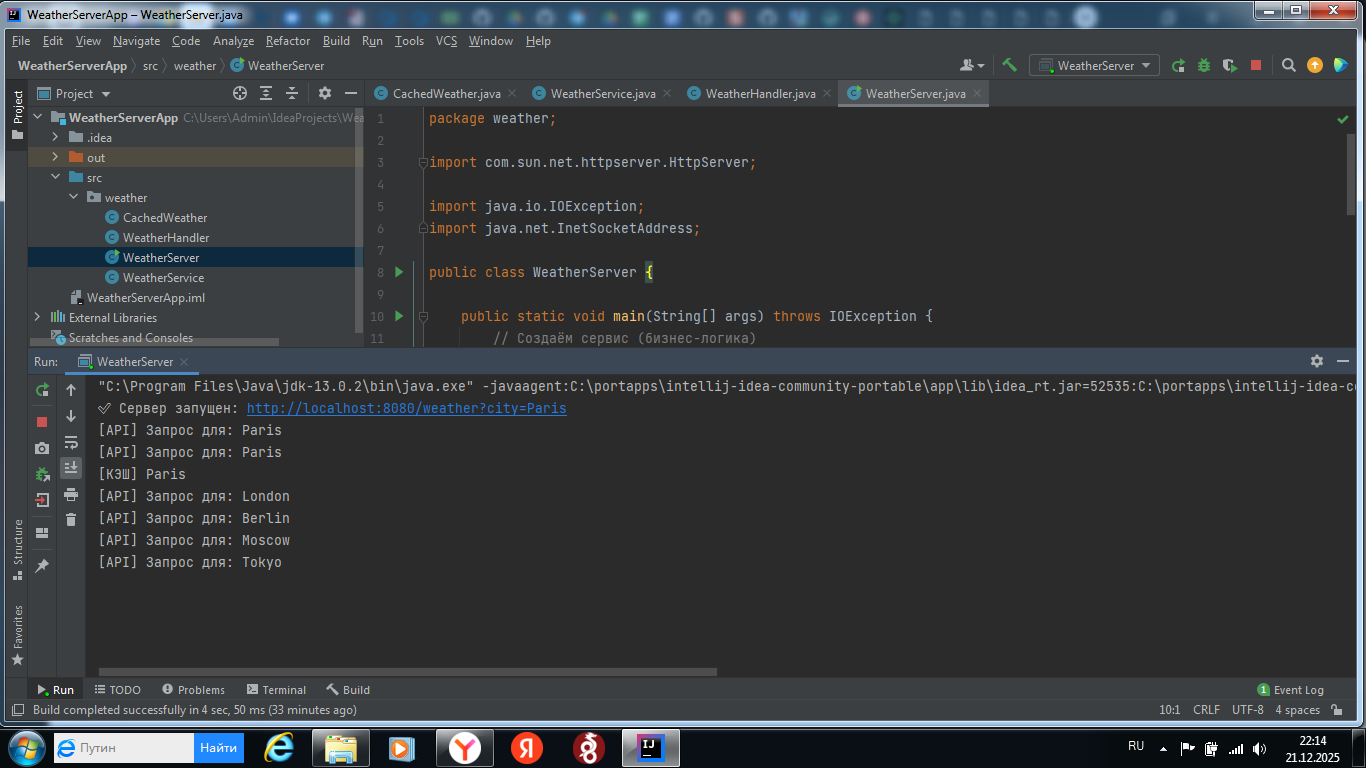

# CachedWeather.java

In [ ]:
package weather;

public class CachedWeather {
    public final double temperature;
    public final long timestamp;

    public CachedWeather(double temperature, long timestamp) {
        this.temperature = temperature;
        this.timestamp = timestamp;
    }
}

# WeatherService.java

In [ ]:
package weather;

import java.io.*;
import java.net.URL;
import java.nio.charset.StandardCharsets;
import java.util.HashMap;
import java.util.Map;
import java.util.concurrent.ConcurrentHashMap;
import java.util.concurrent.Semaphore;
import java.util.Locale;

public class WeatherService {

    // Город → координаты
    private static final Map<String, double[]> CITY_COORDINATES = new HashMap<>();
    static {
        CITY_COORDINATES.put("London", new double[]{51.5085, -0.1257});
        CITY_COORDINATES.put("Paris", new double[]{48.8534, 2.3488});
        CITY_COORDINATES.put("Berlin", new double[]{52.5200, 13.4050});
        CITY_COORDINATES.put("Moscow", new double[]{55.7522, 37.6156});
        CITY_COORDINATES.put("Tokyo", new double[]{35.6895, 139.6917});
    }

    // Потокобезопасный кэш
    private final Map<String, CachedWeather> cache = new ConcurrentHashMap<>();

    // Ограничиваем внешние запросы: не более 2 одновременно
    private final Semaphore apiSemaphore = new Semaphore(2);

    // Получает температуру (с кэшем и ограничением)
    public double getTemperature(String city) throws IOException {
        if (city == null || city.trim().isEmpty()) {
            throw new IllegalArgumentException("City is required");
        }
        city = city.trim();

        // Проверка кэша
        CachedWeather cached = cache.get(city);
        long now = System.currentTimeMillis();
        if (cached != null && now - cached.timestamp < 5 * 60 * 1000) {
            System.out.println("[КЭШ] " + city);
            return cached.temperature;
        }

        // Проверка координат
        double[] coords = CITY_COORDINATES.get(city);
        if (coords == null) {
            throw new IOException("Unknown city: " + city);
        }

        // Формируем URL
        String url = String.format(
                Locale.US,
                "https://api.open-meteo.com/v1/forecast?latitude=%.4f&longitude=%.4f&current_weather=true",
                coords[0], coords[1]
        );

        // Запрос с ограничением
        try {
            apiSemaphore.acquire(); // ждём, если уже 2 запроса
            System.out.println("[API] Запрос для: " + city);
            String jsonResponse = fetchUrl(url);
            double temperature = parseTemperature(jsonResponse);

            // Сохраняем в кэш
            cache.put(city, new CachedWeather(temperature, now));
            return temperature;
        } catch (InterruptedException e) {
            Thread.currentThread().interrupt();
            throw new IOException("Request interrupted", e);
        } finally {
            apiSemaphore.release(); // обязательно освобождаем!
        }
    }

    // Вспомогательный метод: HTTP-запрос
    private String fetchUrl(String urlString) throws IOException {
        URL url = new URL(urlString);
        try (BufferedReader reader = new BufferedReader(
                new InputStreamReader(url.openStream(), StandardCharsets.UTF_8))) {
            StringBuilder sb = new StringBuilder();
            String line;
            while ((line = reader.readLine()) != null) {
                sb.append(line);
            }
            return sb.toString();
        }
    }

    // Очень простой парсинг JSON (для обучения)
    private double parseTemperature(String json) {
        // Находим начало блока "current_weather":{ ... }
        int currentWeatherStart = json.indexOf("\"current_weather\":{");
        if (currentWeatherStart == -1) {
            throw new RuntimeException("Блок 'current_weather' не найден в ответе");
        }

        // Определяем начало поиска температуры — сразу после "{"
        int searchStart = currentWeatherStart + "\"current_weather\":{".length();

        // Находим "temperature" после этого места
        int tempKeyIndex = json.indexOf("\"temperature\":", searchStart);
        if (tempKeyIndex == -1) {
            throw new RuntimeException("Поле 'temperature' не найдено в current_weather");
        }

        // Пропускаем ключ и возможные пробелы
        int valueStart = tempKeyIndex + "\"temperature\":".length();
        while (valueStart < json.length() && Character.isWhitespace(json.charAt(valueStart))) {
            valueStart++;
        }

        // Извлекаем значение до разделителя (запятая или закрывающая скобка)
        int valueEnd = valueStart;
        while (valueEnd < json.length()) {
            char c = json.charAt(valueEnd);
            if (c == ',' || c == '}' || Character.isWhitespace(c)) {
                break;
            }
            valueEnd++;
        }

        if (valueEnd <= valueStart) {
            throw new RuntimeException("Пустое значение температуры");
        }

        String tempStr = json.substring(valueStart, valueEnd);
        try {
            return Double.parseDouble(tempStr);
        } catch (NumberFormatException e) {
            throw new RuntimeException("Не удалось распарсить температуру: '" + tempStr + "' (возможно, это '°C' из units)", e);
        }
    }
}


# WeatherHandler.java

In [ ]:
package weather;

import com.sun.net.httpserver.HttpHandler;
import com.sun.net.httpserver.HttpExchange;

import java.io.IOException;
import java.io.OutputStream;
import java.nio.charset.StandardCharsets;
import java.util.HashMap;
import java.util.Map;

public class WeatherHandler implements HttpHandler {

    private final WeatherService weatherService;

    public WeatherHandler(WeatherService weatherService) {
        this.weatherService = weatherService;
    }

    @Override
    public void handle(HttpExchange exchange) throws IOException {
        if (!exchange.getRequestMethod().equalsIgnoreCase("GET")) {
            sendResponse(exchange, 405, "{\"error\": \"Only GET allowed\"}");
            return;
        }

        String query = exchange.getRequestURI().getQuery();
        String city = parseCityFromQuery(query);

        double temperature;
        try {
            temperature = weatherService.getTemperature(city);
        } catch (Exception e) {
            System.err.println("Ошибка при обработке " + city + ": " + e.getMessage());
            sendResponse(exchange, 500, "{\"error\": \"Internal server error\"}");
            return;
        }

        String response = String.format("{\"city\": \"%s\", \"temperature\": %.1f}", city, temperature);
        sendResponse(exchange, 200, response);
    }

    private String parseCityFromQuery(String query) {
        if (query == null || query.isEmpty()) return "London"; // по умолчанию
        Map<String, String> params = new HashMap<>();
        for (String pair : query.split("&")) {
            String[] parts = pair.split("=", 2);
            if (parts.length == 2) {
                params.put(parts[0], parts[1]);
            }
        }
        return params.getOrDefault("city", "London");
    }

    private void sendResponse(HttpExchange exchange, int statusCode, String json) throws IOException {
        byte[] bytes = json.getBytes(StandardCharsets.UTF_8);
        exchange.getResponseHeaders().set("Content-Type", "application/json; charset=UTF-8");
        exchange.sendResponseHeaders(statusCode, bytes.length);
        try (OutputStream os = exchange.getResponseBody()) {
            os.write(bytes);
        }
    }
}


# WeatherServer.java

In [ ]:
package weather;

import com.sun.net.httpserver.HttpServer;

import java.io.IOException;
import java.net.InetSocketAddress;

public class WeatherServer {

    public static void main(String[] args) throws IOException {
        // Создаём сервис (бизнес-логика)
        WeatherService weatherService = new WeatherService();

        // Создаём HTTP-сервер
        HttpServer server = HttpServer.create(new InetSocketAddress(8080), 0);
        server.createContext("/weather", new WeatherHandler(weatherService));
        server.setExecutor(null); // использует отдельный поток на запрос
        server.start();

        System.out.println("✅ Сервер запущен: http://localhost:8080/weather?city=Paris");
    }
}

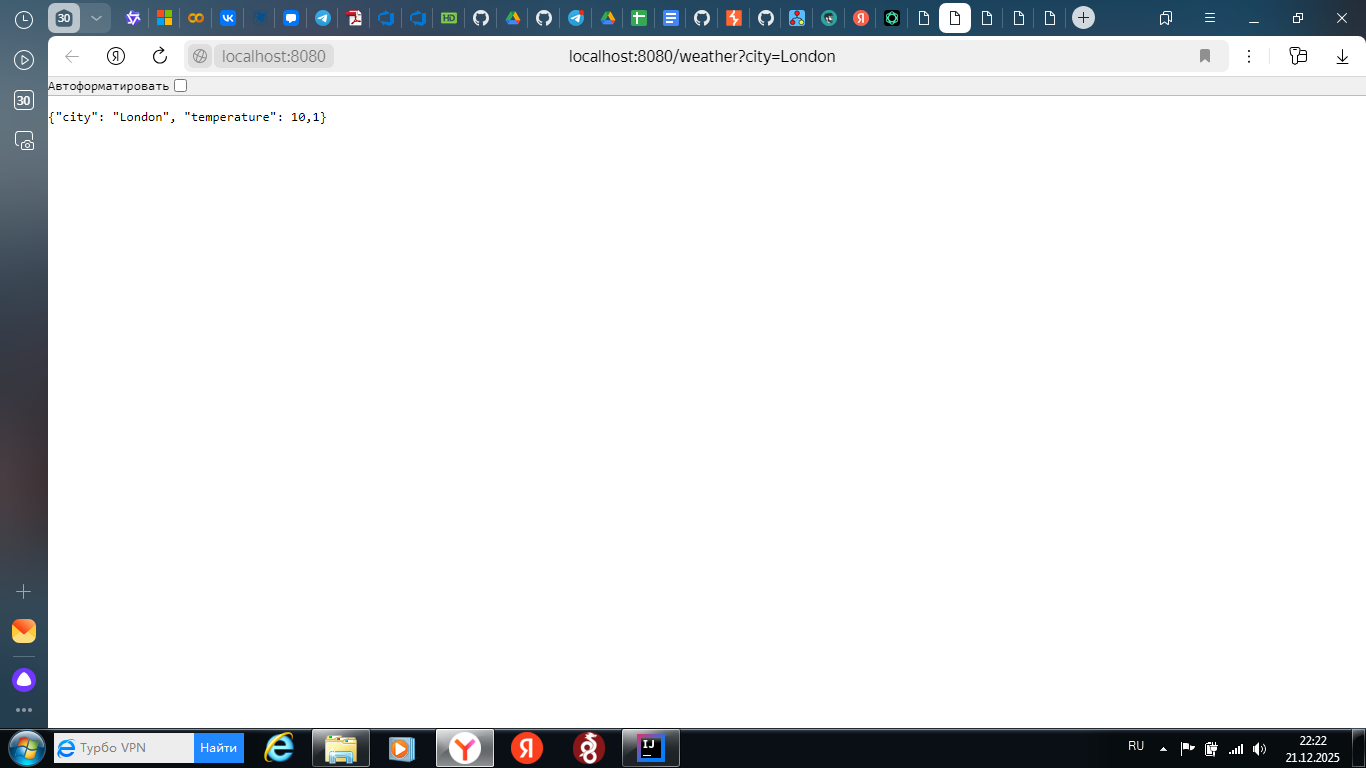